In [1]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms


class CustomImageDataset(Dataset):
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return image, self.labels[index]

    def __len__(self):
        return self.length

In [2]:
transforms_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])

train_data_set = CustomImageDataset(data_set_path="/home/pranjal-ubuntu/Downloads/BrainTumorClassification/data", transforms=transforms_train)
train_loader = DataLoader(train_data_set, batch_size=32, shuffle=True)

In [3]:
batch=next(iter(train_loader))

In [4]:
images = batch[0]
labels = batch[1]

In [5]:
len(batch)

2

In [6]:
type(batch)

list

In [7]:
images.shape

torch.Size([32, 3, 128, 128])

In [8]:
labels.shape

torch.Size([32])

labels : tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0])


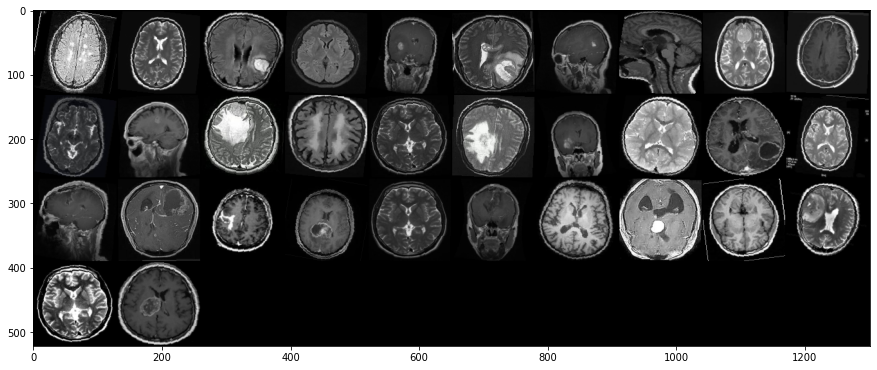

In [9]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print(f"labels : {labels}")

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
import torch.nn as nn

In [15]:
optimizer = optim.Adam(mynetwork.parameters(),lr=0.01)

In [30]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16,32, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32, 64, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64 ,128, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(139392,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [31]:
network2 = CustomNetwork()
print(network2)

CustomNetwork(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=139392, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [32]:
optimizer = optim.Adam(network2.parameters(),lr=0.01)

In [33]:
for epoch in range(5):
    total_loss = 0
    total_correct = 0

    for batch in train_loader:
        images,labels = batch

        preds = network2(images)
        loss = F.cross_entropy(preds,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += get_num_correct(preds,labels)

    print("epoch:",epoch,"total_correct:",total_correct,"loss:",total_loss)  

epoch: 0 total_correct: 2940 loss: 582.5419178307056
epoch: 1 total_correct: 3446 loss: 76.4377863407135
epoch: 2 total_correct: 3520 loss: 72.9233001768589
epoch: 3 total_correct: 3609 loss: 68.25879921019077
epoch: 4 total_correct: 3567 loss: 79.40455988049507


In [34]:
accuracy = (total_correct/len(train_data_set))*100
print(f"Accuracy:{accuracy}")

Accuracy:77.54347826086956
